In [1]:
import os
import sys
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')
np.set_printoptions(threshold=sys.maxsize)

In [2]:
cfw_dict = {
    'Amitabhbachan': 0,
    'AamirKhan': 1,
    'DwayneJohnson': 2,
    'AishwaryaRai': 3,
    'BarackObama': 4,
    'NarendraModi': 5,
    'ManmohanSingh': 6,
    'VladimirPutin': 7
}

opt = {
    'image_size': 32,
    'is_grayscale': False,
    'val_split': 0.75
}

In [3]:
def load_image(path):
    im = Image.open(path).convert('L' if opt['is_grayscale'] else 'RGB')
    im = im.resize((opt['image_size'],opt['image_size']))
    im = np.array(im)
    im = im/256
    return im

def display_images(imgs,classes,row=1,col=2,w=32,h=32):
    fig=plt.figure(figsize=(8, 8))
    for i in range(1, col*row +1):
        img = imgs[i-1]
        fig.add_subplot(row, col, i)
        
        if opt['is_grayscale']:
            plt.imshow(img , cmap='gray') 
        else:
            plt.imshow(img)
        
        plt.title("Class:{}".format(classes[i-1]))
        plt.axis('off')
    plt.show()

def load_data(dir_path):
    image_list = []
    y_list = []
    label_dict = cfw_dict
    for filename in sorted(os.listdir(dir_path)):
        if filename.endswith(".png"):
            im = load_image(os.path.join(dir_path,filename))
            y = filename.split('_')[0]
            y = label_dict[y] 
            image_list.append(im)
            y_list.append(y)
        else:
            continue
    image_list = np.array(image_list)
    y_list = np.array(y_list)
    # print("Dataset shape:",image_list.shape)
    # print("Label shape:",y_list.shape)

    return image_list,y_list

In [4]:
class PCA:
    def __init__(self, data):
        self.data = data
        self.eigenvalues = None
        self.eigenvectors = None

    def preprocess(self):
        mean = np.mean(self.data, axis=0)
        std = np.std(self.data, axis=0)
        self.data = (self.data-mean) / std

    def fit(self, n_components):
        if np.all(self.eigenvalues) == None:
            self.preprocess()
            covariance_matrix = np.cov(self.data.T)
            eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)
            idx = np.argsort(eigenvalues)[::-1]
            self.eigenvalues = eigenvalues[idx]
            self.eigenvectors = eigenvectors[:,idx]
        selected = self.eigenvectors[:, :n_components]
        result = np.dot(self.data, selected)
        # original = np.dot(result, selected.T).reshape(672, 32, 32, 3)
        # original = original.real
        # display_images(original[ind,...],y[ind], row=2,col=3)
        return np.real(result)
    
    def plot(self):
        # self.eigenvalues = self.eigenvalues[:100]
        # idx = range(1, 101)
        cumulative_variance = np.cumsum(self.eigenvalues) / np.sum(self.eigenvalues)
        idx = range(1, len(cumulative_variance)+1)
        plt.figure(figsize=(10, 6))
        plt.plot(idx, cumulative_variance)
        plt.title('Cumulative Explained Variance vs Number of Principal Components')
        plt.xlabel('Number of Principal Components')
        plt.ylabel('Cumulative Explained Varaince')
        plt.grid(True)
        plt.show()

    def plot_1D(self, Z):
        plt.figure(figsize=(10, 6))
        values = range(len(Z))
        plt.plot(values, Z, color='b', alpha=0.7)
        plt.xlabel('Data Point Index')
        plt.ylabel('Principal Component 1')
        plt.title('PCA of data in 1D')
        plt.show()

    def plot_2D(self, Z):
        plt.figure(figsize=(10, 6))
        plt.scatter(Z[:,0], Z[:,1], color='b', alpha=0.7)
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.title('PCA of data in 2D')
        plt.show()

    def plot_3D(self, Z):
        plt.figure(figsize=(10, 6))
        ax = plt.axes(projection='3d')
        ax.scatter(Z[:,0], Z[:,1], Z[:,2], color='b', alpha=0.7)
        ax.set_xlabel('Principal Component 1')
        ax.set_ylabel('Principal Component 2')
        ax.set_zlabel('Principal Component 3')
        ax.set_title('PCA of data in 2D')
        plt.show()

In [5]:
def knn(X, Y):
    x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=0.8, random_state=42)
    knn = KNeighborsClassifier(n_neighbors=7, metric='manhattan')
    knn.fit(x_train, y_train)
    y_pred = knn.predict(x_test)
    return accuracy_score(y_test, y_pred)

- Performed the dimensionality reduction on the IIIT-CFW dataset, varying the number of principal components.
- Plotted the relationship between the cumulative explained variance and the number of principal components.
- Also, plotted the scatter plots for 1D, 2D and 3D data generated after performing PCA on the original data.
- Used the K Nearest Neighbours classifier with k as 7 and manhattan as the distance metric.
- Plotted the accuracies of the classifier pre and post dimensionality reduction (varying the principal components from 1 to n) on the dataset.
- We observe that the post accuracy increases than the pre accuracy for 25 to 35 number of principal components.
- Then, the post accuracy gradually decreases when we increase the number of principal components as the classifier tries to overfit the data.

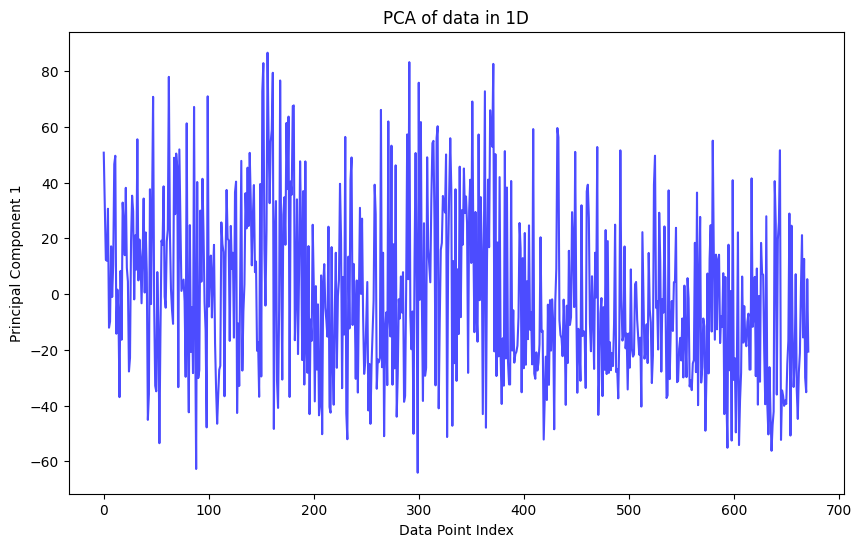

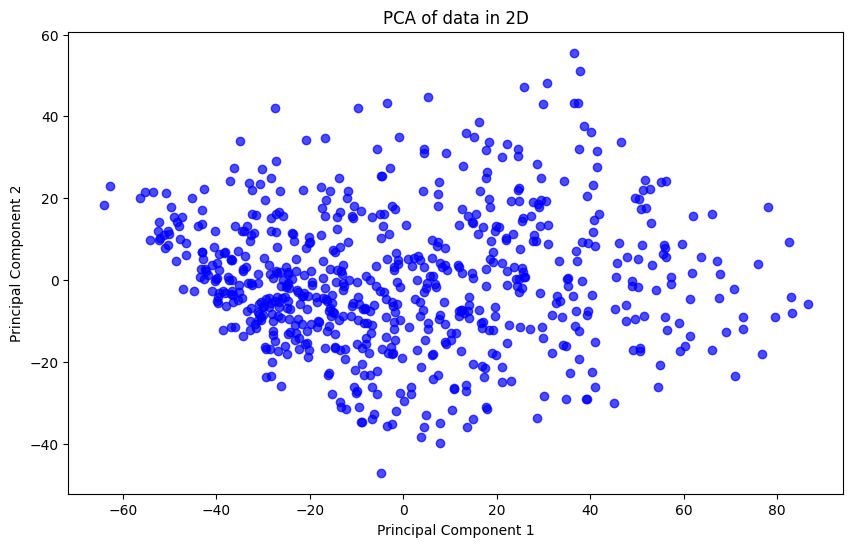

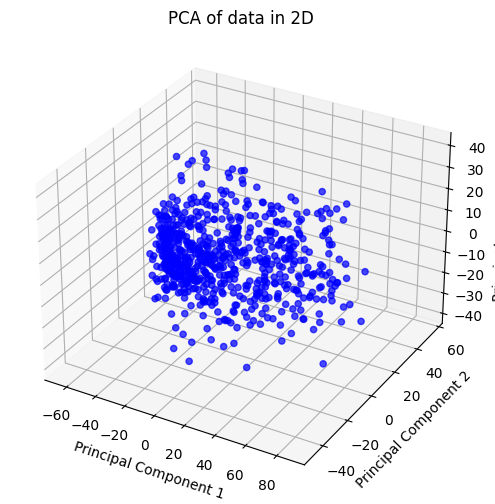

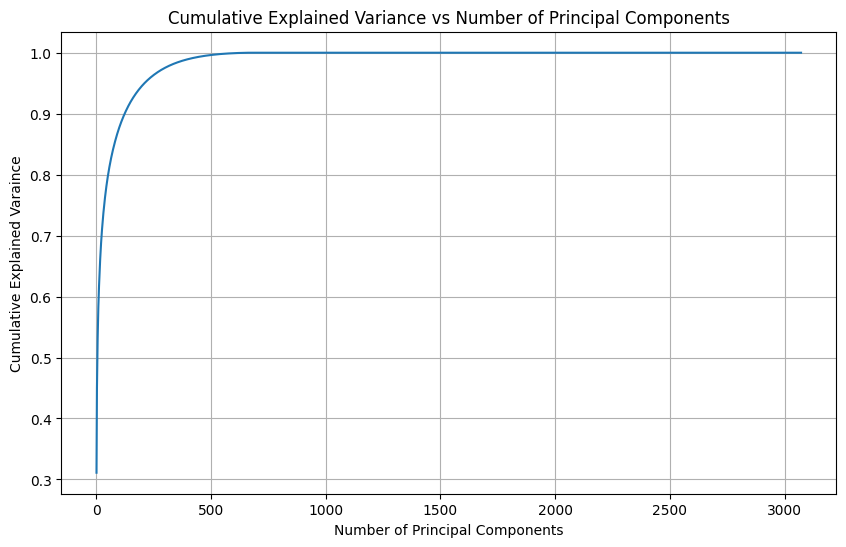

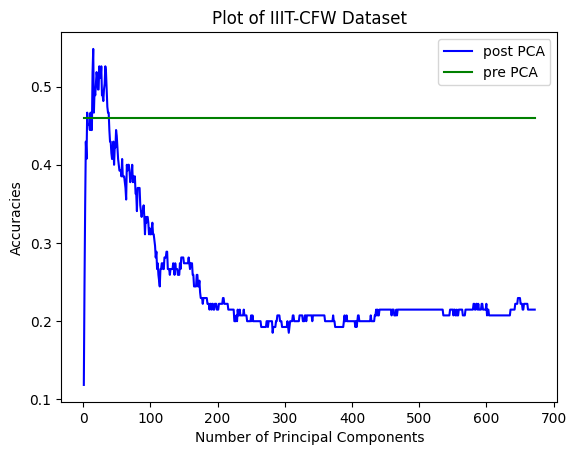

In [6]:
# IIIT-CFW dataset
path = '1/SMAI-Dataset-release/IIIT-CFW/IIIT-CFW/'
X, Y = load_data(path)

# N,H,W = X.shape[0:3]
# C = 1 if opt['is_grayscale'] else X.shape[3]

# ind = np.random.randint(0,y.shape[0],6)
# display_images(X[ind,...],Y[ind], row=2,col=3)

X = X.reshape(672, 3072)
pca = PCA(X)
pre_val = len(X)*[knn(X, Y)]
post_val = []
idx = []
for i in range(len(X)):
    idx.append(i+1)
    Z = pca.fit(i+1)
    post_val.append(knn(Z, Y))
    if i+1==1: pca.plot_1D(Z)
    if i+1==2: pca.plot_2D(Z)
    if i+1==3: pca.plot_3D(Z)
    if i+1==len(X): pca.plot()

plt.plot(idx, post_val, label='post PCA', color='blue')
plt.plot(idx, pre_val, label='pre PCA', color='green')
plt.ylabel('Accuracies')
plt.xlabel('Number of Principal Components')
plt.title('Plot of IIIT-CFW Dataset')
plt.legend()
plt.show()

- Used data.npy dataset from the Assignment-1.
- Used the classifier K Nearest Neighbours with k as 7 and manhattan as the distance metric.
- Plotted the accuracies of the classifier pre and post dimensionality reduction (varying the principal components from 1 to n) on the dataset.
- We observe that the post accuracy increases than the pre accuracy for 25-35 number of principal components.
- Then, the post accuracy gradually decreases when we increase the number of principal components as the classifier tries to overfit the data.
- The post accuracy for higher number of principal components become almost constant and does not vary much.
- Also, plotted the scatter plots for 1D, 2D and 3D data generated after performing PCA on the original data.

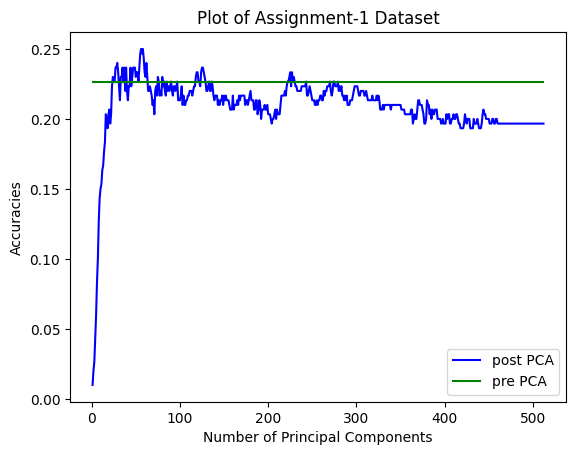

In [7]:
# Assignment-1 data
data = np.load('1/data.npy', 'r', True)
X = []
Y = []
for vec in data:
    X.append(vec[2][0])
    Y.append(vec[3])

num = len(data[0][2].T)
pca = PCA(X)
pre_val = num*[knn(X, Y)]
post_val = []
idx = []
for i in range(num):
    idx.append(i+1)
    Z = pca.fit(i+1)
    post_val.append(knn(Z, Y))

plt.plot(idx, post_val, label='post PCA', color='blue')
plt.plot(idx, pre_val, label='pre PCA', color='green')
plt.ylabel('Accuracies')
plt.xlabel('Number of Principal Components')
plt.title('Plot of Assignment-1 Dataset')
plt.legend()
plt.show()

- Performed the PCA on drawer and guesser data of the Pictionary dataset provided.
- The first principal axis accounts for the maximum variance of the data among all the possible axes.
- Each subsequent principal axes capture less variance and are orthogonal to the previous ones.
- Plotted the relationship between the cumulative explained variance and the number of principal components.
- Also, plotted the scatter plots for 1D, 2D and 3D data generated after performing PCA on the original data.

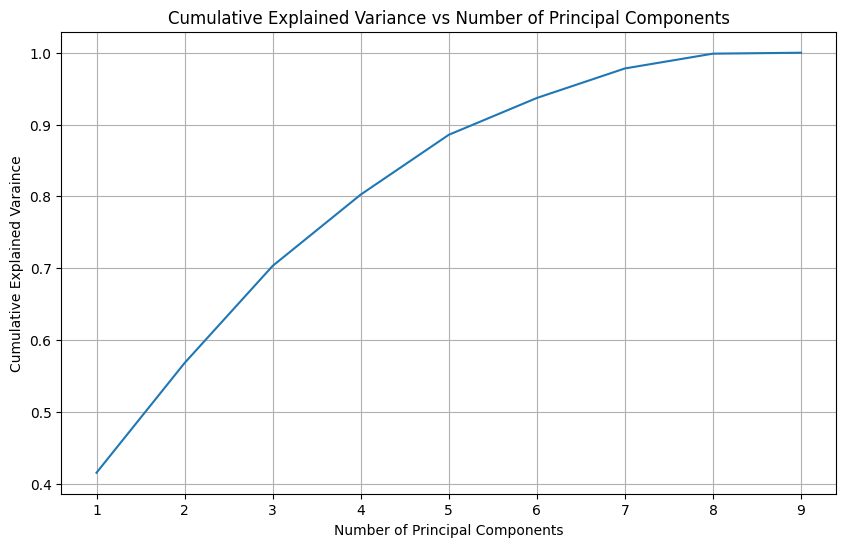

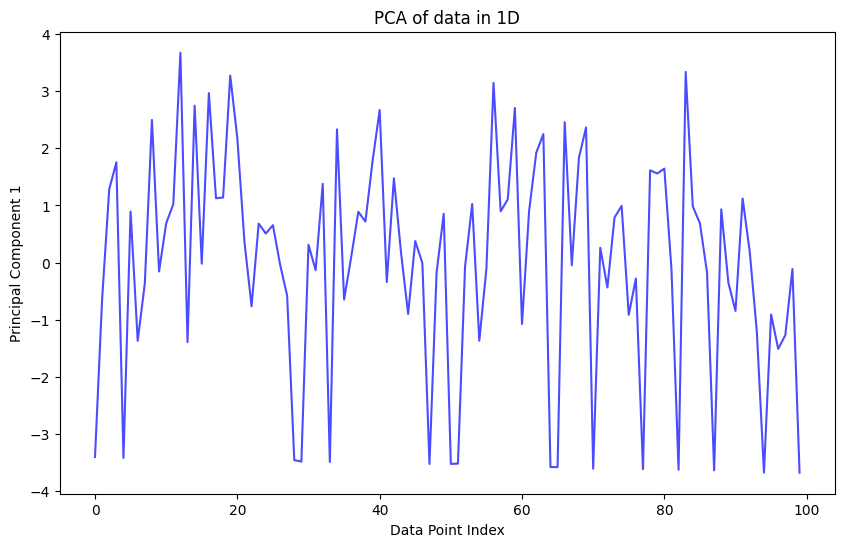

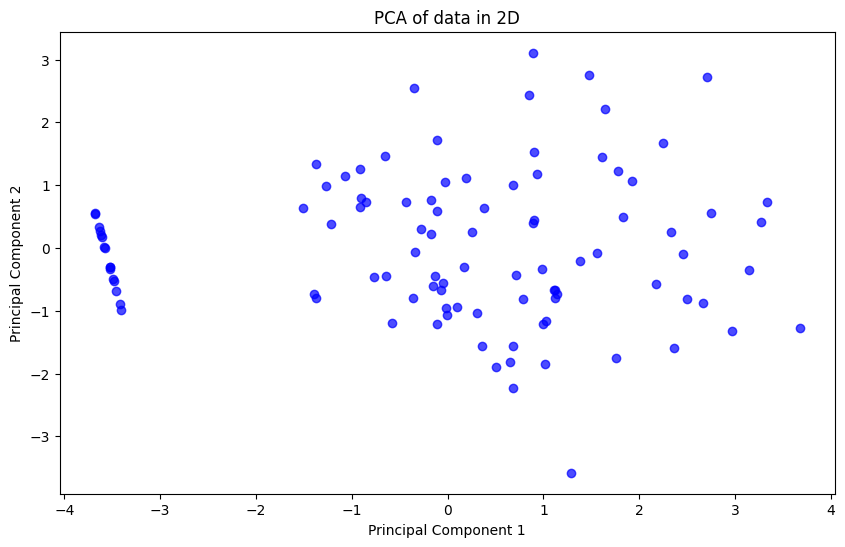

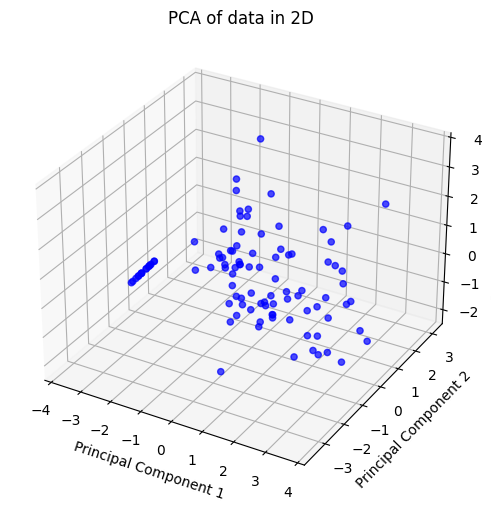

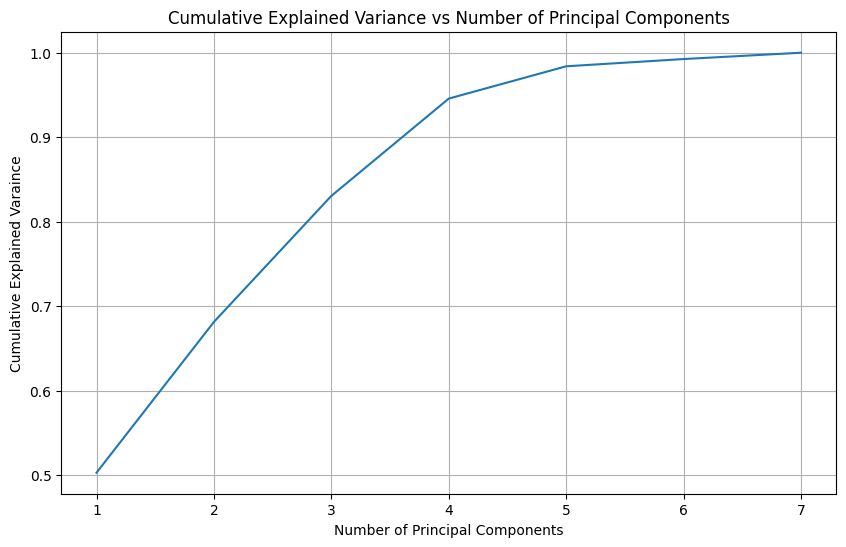

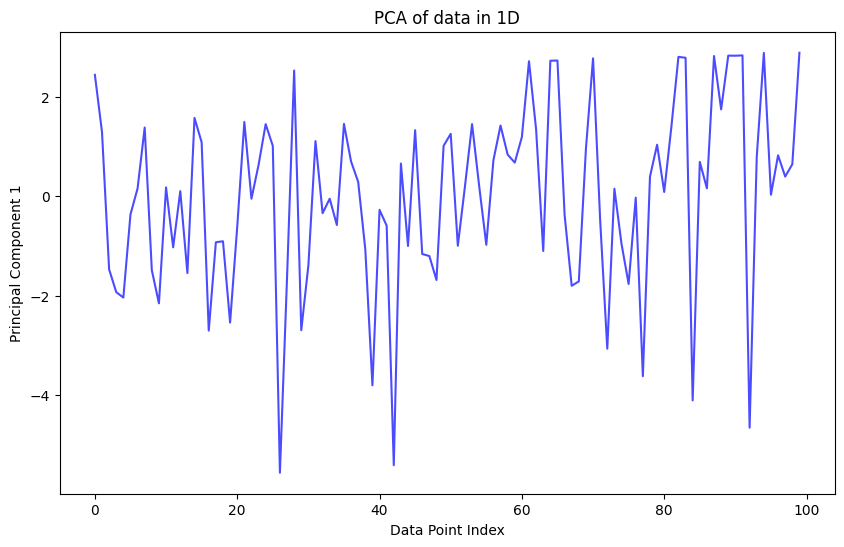

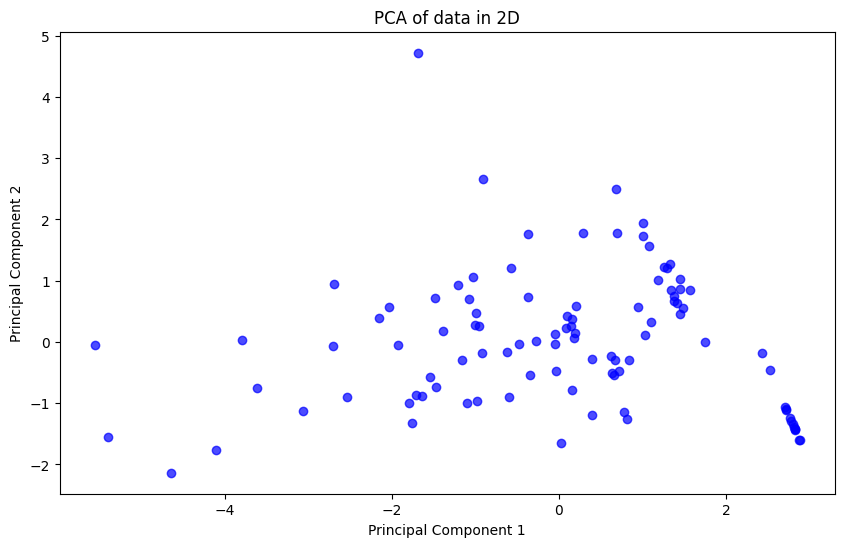

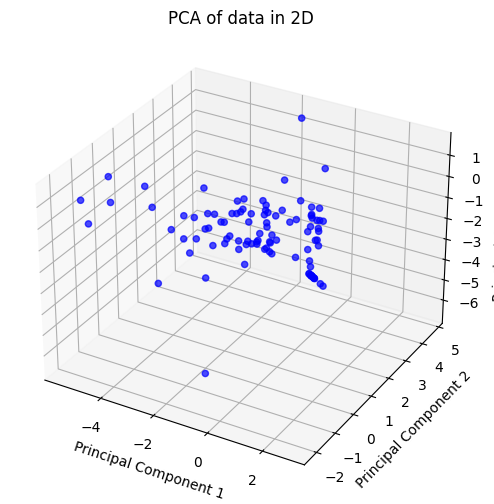

In [8]:
# Pictionary Dataset
### Drawer data -- 100 x 9
path = '1/smai_assignment_pictionary/drawer_attributes.csv'
drawer = pd.read_csv(path).to_numpy()
pca = PCA(drawer)
Z = pca.fit(9)
pca.plot()
Z = pca.fit(1)
pca.plot_1D(Z)
Z = pca.fit(2)
pca.plot_2D(Z)
Z = pca.fit(3)
pca.plot_3D(Z)

### guesser data -- 100 x 7
path = '1/smai_assignment_pictionary/guesser_attributes.csv'
guesser = pd.read_csv(path).to_numpy()
pca = PCA(guesser)
Z = pca.fit(7)
pca.plot()
Z = pca.fit(1)
pca.plot_1D(Z)
Z = pca.fit(2)
pca.plot_2D(Z)
Z = pca.fit(3)
pca.plot_3D(Z)